In [1]:
import pandas as pd

pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data
import pandas
import  numpy as np
from datetime import datetime, timedelta

import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

pd.options.mode.chained_assignment = None


from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool

from bokeh.models import LinearAxis, Range1d
output_notebook()

from bokeh.palettes import Category20 as palettes
# itertools handles the cycling
import itertools 

colors = itertools.cycle(palettes[20]) 


%matplotlib notebook

Loading BokehJS ...

In [2]:
path= "~/Desktop/tmp/SPY.csv"

df=pd.read_csv(path, delimiter=",")

df.head()

Dates     Open    Close     High      Low
0  11/16/18 22:30  2718.54  2716.39  2718.54  2716.26
1  11/16/18 22:31  2716.53  2718.58  2719.99  2716.53
2  11/16/18 22:32  2718.73  2717.48  2719.59  2717.13
3  11/16/18 22:33  2717.27  2718.60  2719.70  2716.95
4  11/16/18 22:34  2718.39  2716.17  2718.60  2716.17

# convert timezone to ny time

In [3]:
df.Dates=pd.to_datetime(df.Dates)
df=df.set_index('Dates')


df= df.tz_localize(tz='Hongkong')
df = df.tz_convert('US/Eastern')

In [4]:
day=datetime.strptime('2018-01-01 04:59:59', '%Y-%m-%d %H:%M:%S')
df = df[day:]
resampled_df = df.resample('1min').interpolate(method='linear')
market = "EQ"
#HKG TIME
#futures 
if market =="FT":
    resampled_df = resampled_df[
                    
                        ( (resampled_df.index.weekday >0) & (resampled_df.index.weekday <= 5)  & (resampled_df.index.hour<=4))
                        | ((resampled_df.index.weekday<=4) & (resampled_df.index.hour>=6)) 
                        

                        #| ((resampled_df.index.weekday==6) & (resampled_df.index.hour>=22))
                       ]
elif market == "FX":
    resampled_df =resampled_df[ ((resampled_df.index.weekday <= 4)  & (resampled_df.index.hour<=4))
                        | ((resampled_df.index.weekday<=4) & (resampled_df.index.hour>=5)) 
                        | ((resampled_df.index.weekday==5) & (resampled_df.index.hour<=4))
                       ]
elif market == "EQ":
    print(" Equity")
    resampled_df =resampled_df[ 
        
                        ( (resampled_df.index.weekday >=0) & (resampled_df.index.weekday <= 4) 
                        & ( ((resampled_df.index.hour>9) & (resampled_df.index.hour<16))
                          | ((resampled_df.index.hour==9) & (resampled_df.index.minute>=30))
                         | ((resampled_df.index.hour==16) & (resampled_df.index.minute==0))
                         )
                        )
                      
                        
                       ]
elif market =="CRYPTO":
    print("Crypto")


resampled_df['hour']=resampled_df.index.hour
resampled_df['minute']=resampled_df.index.minute
resampled_df['weekday']=resampled_df.index.weekday

 Equity


In [5]:
resampled_df.head()

Open    Close     High      Low  hour  minute  \
Dates                                                                         
2018-11-16 09:30:00-05:00  2718.54  2716.39  2718.54  2716.26     9      30   
2018-11-16 09:31:00-05:00  2716.53  2718.58  2719.99  2716.53     9      31   
2018-11-16 09:32:00-05:00  2718.73  2717.48  2719.59  2717.13     9      32   
2018-11-16 09:33:00-05:00  2717.27  2718.60  2719.70  2716.95     9      33   
2018-11-16 09:34:00-05:00  2718.39  2716.17  2718.60  2716.17     9      34   

                           weekday  
Dates                               
2018-11-16 09:30:00-05:00        4  
2018-11-16 09:31:00-05:00        4  
2018-11-16 09:32:00-05:00        4  
2018-11-16 09:33:00-05:00        4  
2018-11-16 09:34:00-05:00        4

In [6]:
plot_df = resampled_df


hover = HoverTool()

hover.tooltips = [
    ("x, y", "@x,@y"), 
]
colNameList=['Open','Close','High','Low']
p=figure( x_axis_type='datetime')
coloer=['red','yellow','green','blue','orange']
tf=[5,10,15,30,60]
for i in range(len(colNameList)):
    p.line(x=plot_df.index ,y=plot_df[colNameList[i]], 
           color=next(colors),legend=colNameList[i]
           )
    
p.tools.append(hover)
show(p)

In [7]:
plot_df = resampled_df['2019-01-16']
plot_df.tail(5)

Open    Close     High      Low  hour  minute  \
Dates                                                                         
2019-01-16 15:56:00-05:00  2618.80  2618.55  2619.36  2618.54    15      56   
2019-01-16 15:57:00-05:00  2618.65  2616.72  2618.65  2616.31    15      57   
2019-01-16 15:58:00-05:00  2616.75  2615.57  2617.05  2615.42    15      58   
2019-01-16 15:59:00-05:00  2615.46  2615.68  2617.42  2615.05    15      59   
2019-01-16 16:00:00-05:00  2615.70  2615.82  2615.82  2615.69    16       0   

                           weekday  
Dates                               
2019-01-16 15:56:00-05:00        2  
2019-01-16 15:57:00-05:00        2  
2019-01-16 15:58:00-05:00        2  
2019-01-16 15:59:00-05:00        2  
2019-01-16 16:00:00-05:00        2

In [8]:
plot_df['log_price']=np.log(plot_df['Close'])
plot_df['log_return']=plot_df['log_price']- plot_df['log_price'].shift(1)

In [22]:
plot_df['rolling_std'] = plot_df['log_return'].rolling(5).std()
#plot_df['rolling_std'].plot()


<IPython.core.display.Javascript object>


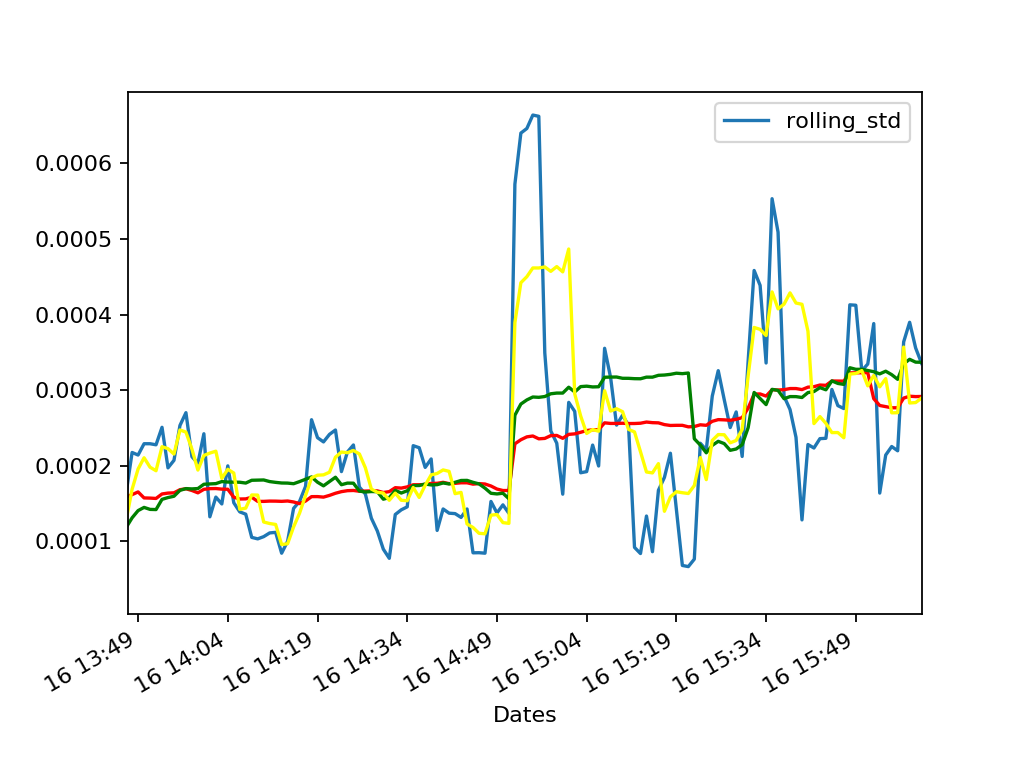

In [25]:
plot_df[['rolling_std']].plot()
plot_df['log_return'].rolling(60).std().plot(color="red")
plot_df['log_return'].rolling(30).std().plot(color='green')
plot_df['log_return'].rolling(10).std().plot(color='yellow')

<IPython.core.display.Javascript object>


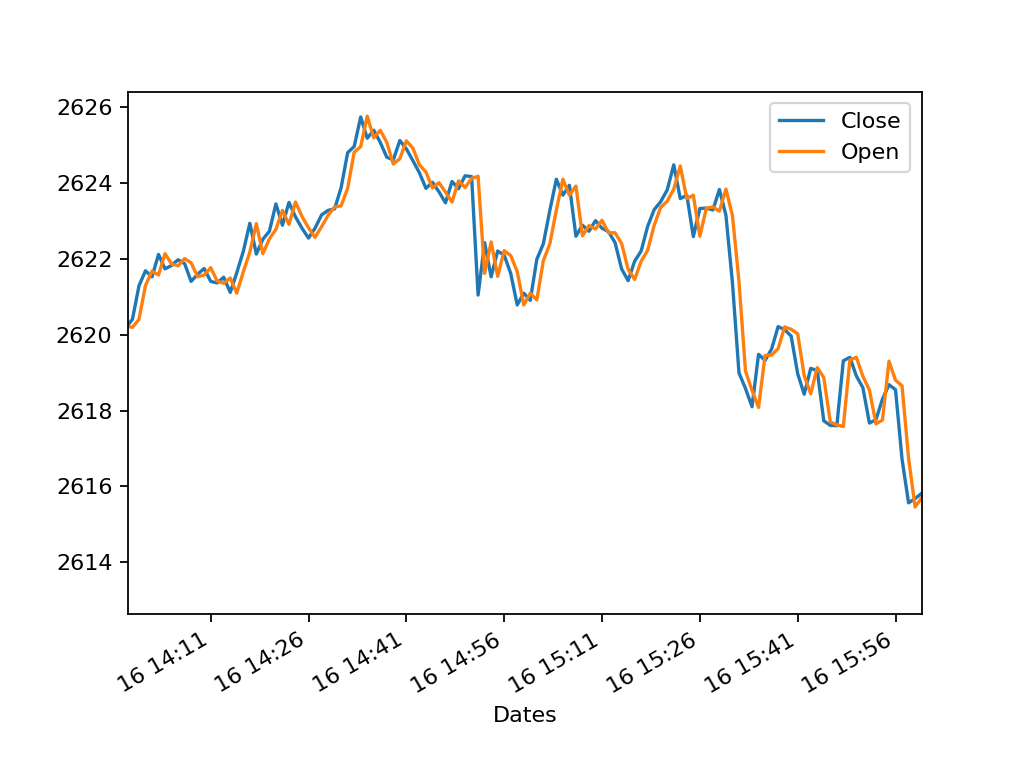

In [27]:
plot_df[['Close','Open']].plot()

In [33]:
start=datetime.strptime('2019-01-16 14:30:00', '%Y-%m-%d %H:%M:%S')
close=datetime.strptime('2019-01-16 14:58:00', '%Y-%m-%d %H:%M:%S')
plot_df[day:close]

Open    Close     High      Low  hour  minute  \
Dates                                                                         
2019-01-16 14:30:00-05:00  2623.36  2623.31  2623.54  2623.14    14      30   
2019-01-16 14:31:00-05:00  2623.39  2623.87  2623.90  2623.30    14      31   
2019-01-16 14:32:00-05:00  2623.85  2624.79  2625.01  2623.83    14      32   
2019-01-16 14:33:00-05:00  2624.80  2624.95  2625.17  2624.78    14      33   
2019-01-16 14:34:00-05:00  2624.95  2625.73  2625.74  2624.95    14      34   
2019-01-16 14:35:00-05:00  2625.75  2625.17  2625.76  2625.15    14      35   
2019-01-16 14:36:00-05:00  2625.18  2625.38  2625.71  2625.17    14      36   
2019-01-16 14:37:00-05:00  2625.38  2625.06  2625.40  2625.04    14      37   
2019-01-16 14:38:00-05:00  2625.06  2624.67  2625.16  2624.60    14      38   
2019-01-16 14:39:00-05:00  2624.49  2624.60  2624.69  2624.43    14      39   
2019-01-16 14:40:00-05:00  2624.63  2625.11  2625.11  2624.63    14      40   
2019-01-16 14:41:00-05:00  2625.10  2624.89  2625.49  2624.89    14      41   
2019-01-16 14:42:00-05:00  2624.91  2624.58  2624.91  2624.58    14      42   
2019-01-16 14:43:00-05:00  2624.47  2624.26  2624.48  2624.26    14      43   
2019-01-16 14:44:00-05:00  2624.28  2623.85  2624.31  2623.69    14      44   
2019-01-16 14:45:00-05:00  2623.86  2624.01  2624.05  2623.77    14      45   
2019-01-16 14:46:00-05:00  2624.00  2623.76  2624.18  2623.75    14      46   
2019-01-16 14:47:00-05:00  2623.75  2623.47  2623.75  2623.30    14      47   
2019-01-16 14:48:00-05:00  2623.49  2624.03  2624.07  2623.49    14      48   
2019-01-16 14:49:00-05:00  2624.05  2623.84  2624.07  2623.62    14      49   
2019-01-16 14:50:00-05:00  2623.87  2624.18  2624.18  2623.87    14      50   
2019-01-16 14:51:00-05:00  2624.11  2624.16  2624.28  2624.11    14      51   
2019-01-16 14:52:00-05:00  2624.17  2621.04  2624.17  2620.92    14      52   
2019-01-16 14:53:00-05:00  2621.61  2622.42  2623.03  2621.61    14      53   
2019-01-16 14:54:00-05:00  2622.44  2621.52  2622.44  2621.41    14      54   
2019-01-16 14:55:00-05:00  2621.53  2622.20  2622.23  2621.34    14      55   
2019-01-16 14:56:00-05:00  2622.21  2622.09  2622.24  2621.87    14      56   
2019-01-16 14:57:00-05:00  2622.08  2621.61  2622.08  2621.39    14      57   
2019-01-16 14:58:00-05:00  2621.66  2620.78  2621.70  2620.78    14      58   

                           weekday  log_price  log_return  rolling_std  
Dates                                                                   
2019-01-16 14:30:00-05:00        2   7.872192    0.000015     0.000090  
2019-01-16 14:31:00-05:00        2   7.872406    0.000213     0.000078  
2019-01-16 14:32:00-05:00        2   7.872756    0.000351     0.000136  
2019-01-16 14:33:00-05:00        2   7.872817    0.000061     0.000142  
2019-01-16 14:34:00-05:00        2   7.873114    0.000297     0.000146  
2019-01-16 14:35:00-05:00        2   7.872901   -0.000213     0.000227  
2019-01-16 14:36:00-05:00        2   7.872981    0.000080     0.000224  
2019-01-16 14:37:00-05:00        2   7.872859   -0.000122     0.000198  
2019-01-16 14:38:00-05:00        2   7.872710   -0.000149     0.000209  
2019-01-16 14:39:00-05:00        2   7.872684   -0.000027     0.000115  
2019-01-16 14:40:00-05:00        2   7.872878    0.000194     0.000143  
2019-01-16 14:41:00-05:00        2   7.872794   -0.000084     0.000137  
2019-01-16 14:42:00-05:00        2   7.872676   -0.000118     0.000137  
2019-01-16 14:43:00-05:00        2   7.872554   -0.000122     0.000132  
2019-01-16 14:44:00-05:00        2   7.872398   -0.000156     0.000143  
2019-01-16 14:45:00-05:00        2   7.872459    0.000061     0.000085  
2019-01-16 14:46:00-05:00        2   7.872364   -0.000095     0.000085  
2019-01-16 14:47:00-05:00        2   7.872253   -0.000111     0.000084  
2019-01-16 14:48:00-05:00        2   7.872467    0.000213     0.000153  
2019-01-16 14:49:00-05:00        2   7.872394  

<IPython.core.display.Javascript object>


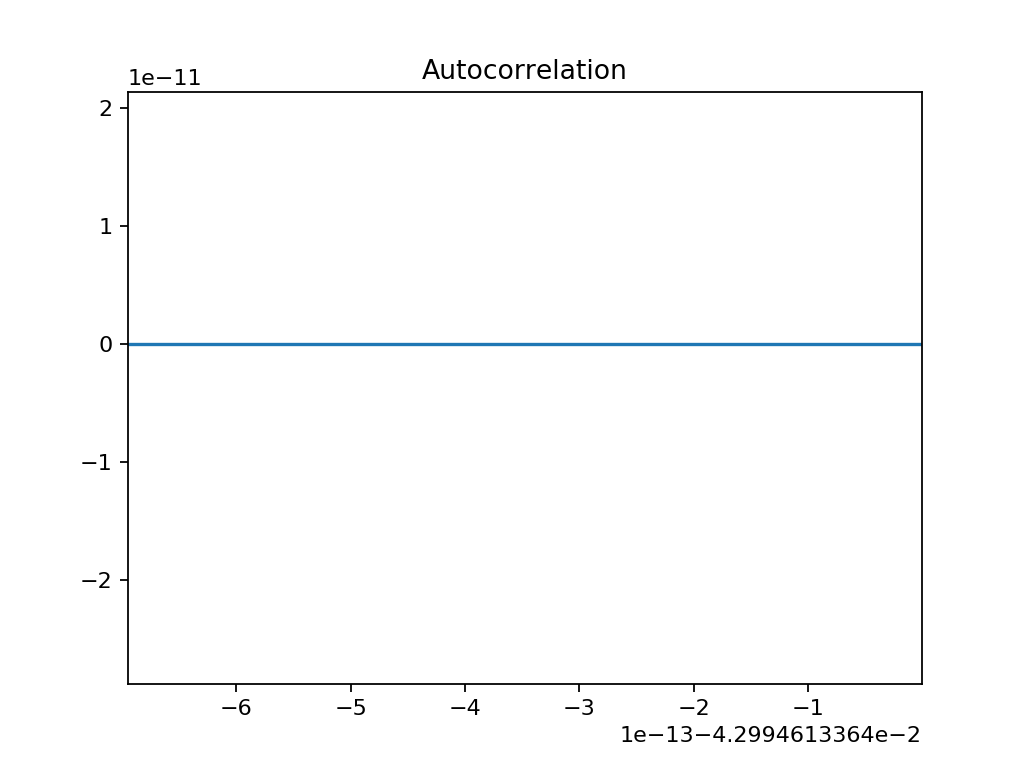

<IPython.core.display.Javascript object>


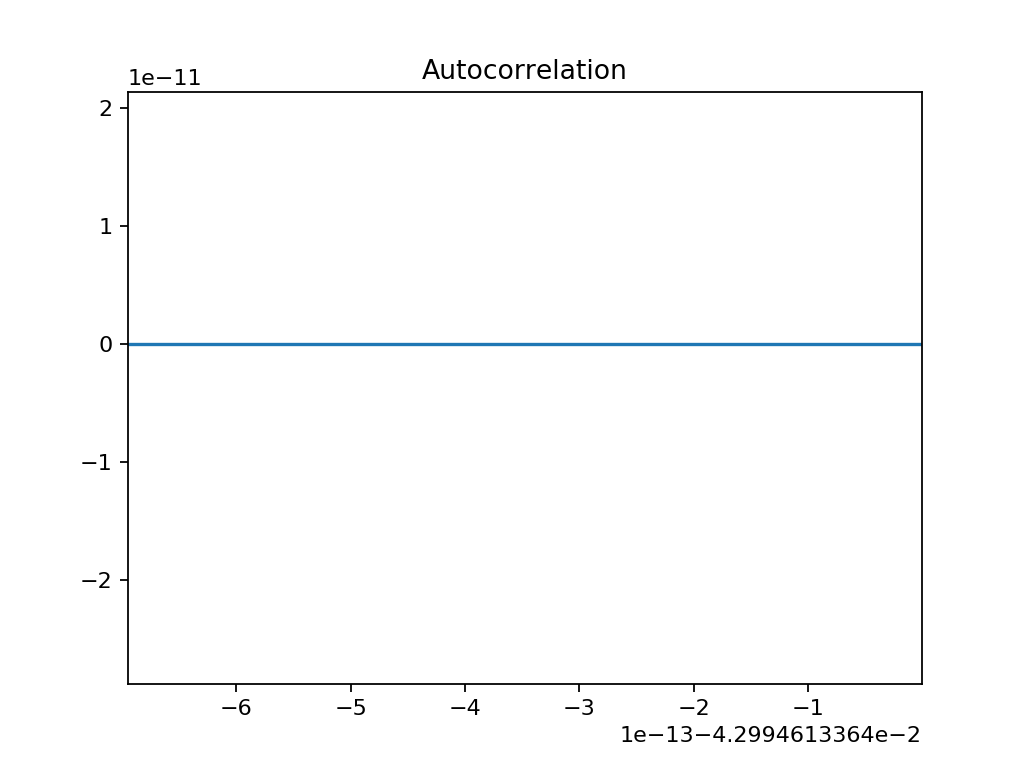

In [41]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(plot_df['log_return'], lags=60)